# Sentiment Analysis of Foodpanda's consumer reviews

**Source:** *Google Playstore* <br>

```
Author: Teoh Sin Yee
Author: Wan Muhamad Rusyaidi Afifi
```




In [ ]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

We will be working with a .csv file that contains information about tens of thousands of customers writing reviews on Amazon products from June 2021 - Dec 2021. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). In this way, the following attributes are available in the data:

1. **username (text):** registered user profile name.
2. **score (ordinal):** rating between 1 and 5.
3. **at (numerical):** date of the review.
4. **content (text):** text of the review.

## Reading and performing basic analysis of the data

As usual the first step is to read the available data and perform some high-level analysis on it:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
foodpanda_reviews = pd.read_csv('scrapped_data.csv')
foodpanda_reviews.head(3)

,userName,score,at,content
0,C Ds,4,22/11/2021,It's pretty good for where I live since most p...
1,Gopa Banik,5,22/11/2021,So fast delivery... I can eat whatever i want..
2,Blessyl Fejer,2,22/11/2021,Sometime when it comes to 50% off promo some r...


Let's look at the distribution of number of words per review. We will do this by applying a *lambda* function that splits each complete review by spaces, which will give us the borad words:

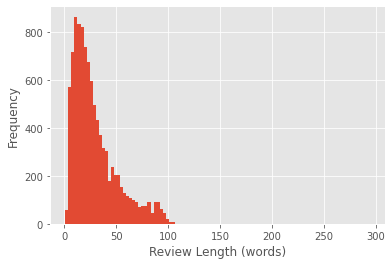

In [ ]:
## Getting the number of words by splitting them by a space
words_per_review = foodpanda_reviews.content.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 29.5527
Skewness: 1.395108693927331


We can see that the number of words per user review is highly positive skewed with mean of 29, which means that on average, user reviews have 29 words.

Let's also look at the distribution of ratings:

Let's also look at the distribution of ratings:

In [ ]:
percent_val = 100 * foodpanda_reviews['score'].value_counts()/len(foodpanda_reviews)
percent_val

1    42.65
5    26.15
4    12.10
3     9.87
2     9.23
Name: score, dtype: float64

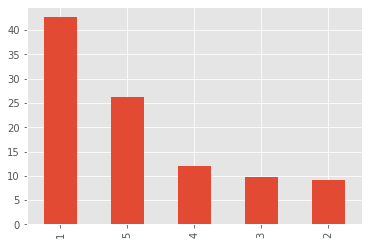

In [ ]:
percent_val.plot.bar()
plt.show()

The distribution is quite skewed, with a giant number of 1s and very few 4s, 3s, and 2s.

### Text visualization using word clouds (*word clouds* )

As visualization is crucial for numerical data, it is also important for text data. However, the text does not lend itself to histogram charts or scatterplots, as numerical data does. In such cases, the **word clouds** are a common and very useful tool to appreciate the text distribution.

To make a word cloud of the string values of the Series `data['content']`, we are going to import the `WordCloud` package (if it is not installed, you can proceed to install it with `pip install wordcloud`) and join all the text with the `.join()` method:

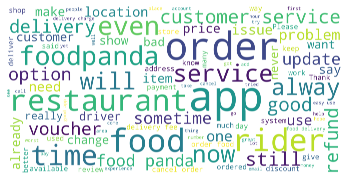

In [ ]:
word_cloud_text = ''.join(foodpanda_reviews['content'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

The word cloud indicates that many of the reviews talk about restaurant, refund, service, order. We also see some negative words like issue, refund, as well as not desired ones such as foodpanda (brand name),even(adjective),and already (adverb).

KIV
For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule: 
- Ratings of 4 or 5 will get mapped to 1 and will be reltead to positive reviews
- Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews
- Ratings of 3 will get removed since they will represent neutral reviews.

In [ ]:
# Mapping the ratings
foodpanda_reviews['Sentiment_rating'] = np.where(foodpanda_reviews.score > 3,1,0)

## Removing neutral reviews 
foodpanda_reviews = foodpanda_reviews[foodpanda_reviews.score != 3]

# Printing the counts of each class
foodpanda_reviews['Sentiment_rating'].value_counts()

0    5188
1    3825
Name: Sentiment_rating, dtype: int64

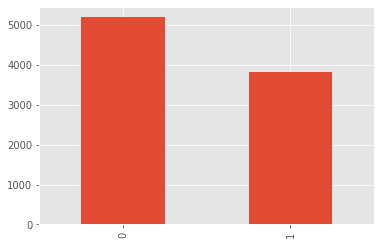

In [ ]:
foodpanda_reviews.Sentiment_rating.value_counts().plot.bar()
plt.show()

There is a class imbalance that we are going to handle by defining robust metrics.

## Pre-processing

1. Converting words to lower/upper case
2. Removing special characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization



### 1. Converting words to lower/upper case

Let's start by converting all of the words into a consistent case format, say lowercase:

In [ ]:
foodpanda_reviews['reviews_text_new'] = foodpanda_reviews['content'].str.lower()

In the following code cell we analyze the number of unique words that are found in reviews before and after applying this step. This process of extracting individual words is called **word tokenization**, and can be run using the `word_tokenize` function in the `nltk` package:

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk import word_tokenize

# Word tokenization example:
word_tokenize("DPhi Bootcamp rules. It is awesome :D")

['DPhi', 'Bootcamp', 'rules', '.', 'It', 'is', 'awesome', ':', 'D']

In [ ]:
# For reviews not converted to lower case
token_lists = [word_tokenize(each) for each in foodpanda_reviews['content']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lowe case
token_lists_lower = [word_tokenize(each) for each in foodpanda_reviews['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  14933
Number of unique tokens now:  12169


The number of tokens has gone down by ~18% just from normalizing the corpus.

Removing special characters is a subjective call, especially in cases like this one. People often use special characters to express their emotions and might leave a review like _'This product is the worst!!!'_, while a positive review could be like _'This product is the best. Loved it!'_. Here, the presence of exclamation marks clearly indicates something about the underlying sentiment, so removing them may well not be a good idea.

On the other hand, removing non-emotionally charged punctuation such as commas, periods, and semicolons is likely safe.

### 2. Removing special characters

In [ ]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = foodpanda_reviews['reviews_text_new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '|',
 '~',
 '×',
 '̀',
 '́',
 '̇',
 '।',
 'া',
 'ে',
 '\u200b',
 '\u200d',
 '–',
 '—',
 '’',
 '“',
 '”',
 '…',
 '‸',
 '‼',
 '₱',
 '√',
 '◞',
 '◟',
 '★',
 '☑',
 '☹',
 '☺',
 '♀',
 '♂',
 '♡',
 '♥',
 '✅',
 '✋',
 '✌',
 '✝',
 '✨',
 '❌',
 '❗',
 '❣',
 '❤',
 '⭐',
 '。',
 '️',
 '！',
 '，',
 '？',
 '￼',
 '🅒',
 '🅛',
 '🅞',
 '🇰',
 '🇲',
 '🇵',
 '🇾',
 '🌚',
 '🌝',
 '🌞',
 '🌟',
 '🌼',
 '🍜',
 '🎉',
 '🏠',
 '🏻',
 '🏼',
 '🏽',
 '🐔',
 '🐕',
 '🐸',
 '🐼',
 '👀',
 '👁',
 '👄',
 '👆',
 '👈',
 '👉',
 '👊',
 '👌',
 '👍',
 '👎',
 '👏',
 '👑',
 '👹',
 '💀',
 '💐',
 '💓',
 '💕',
 '💖',
 '💗',
 '💚',
 '💜',
 '💝',
 '💞',
 '💟',
 '💢',
 '💩',
 '💪',
 '💯',
 '📍',
 '🖕',
 '🖤',
 '😀',
 '😁',
 '😂',
 '😃',
 '😄',
 '😅',
 '😆',
 '😇',
 '😉',
 '😊',
 '😋',
 '😌',
 '😍',
 '😎',
 '😏',
 '😐',
 '😑',
 '😒',
 '😓',
 '😔',
 '😕',
 '😖',
 '😗',
 '😘',
 '😚',
 '😜',
 '😝',
 '😞',
 '😠',
 '😡',
 '😢',
 '😣',
 '😤',
 '😥',
 '😩',
 '😪',
 '😫',

Let's remove these special characters from the reviews by applying a regular expression:

In [ ]:
review_backup = foodpanda_reviews['reviews_text_new'].copy()
foodpanda_reviews['reviews_text_new'] = foodpanda_reviews['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

Let's decomose the regular expression `[^A-Za-z0-9 ]+`:
- `[ ]`: match any character inside the list defined by the square brackets, including the space character `' '`
- `^`: start of the line
- `A-Z`: accept english upper case characters from A to Z
- `a-z`: accept english lower case characters from a to z
- `0-9`: accept single number characters from 0 to 9

We can see how our reviews change after removing these:

In [ ]:
print("- Old Review -")
print(review_backup.values[6])
print("\n- New Review -")
print(foodpanda_reviews['reviews_text_new'][6])

- Old Review -
dear fp, hei tolong lah include id for ur riders like grab. im a regular customers n this is not the first time this happened. everytime i made cod orders there are no problems. but when i made online payment, mcm2 hal jadi dekat order saya. cancel lah, tulis delivered tapi makanan tk sampai. do something!!!!!!!!

- New Review -
dear fp  hei tolong lah include id for ur riders like grab  im a regular customers n this is not the first time this happened  everytime i made cod orders there are no problems  but when i made online payment  mcm2 hal jadi dekat order saya  cancel lah  tulis delivered tapi makanan tk sampai  do something 


The number of unique tokens has dropped further:

In [ ]:
token_lists = [word_tokenize(each) for each in foodpanda_reviews['content']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in foodpanda_reviews['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  14933
Number of unique tokens now:  9706


### 3. Stopwords and high/low frequency words

Stopwords naturally occur very frequently in the English language without adding any context specific insights. It makes sense to remove them. Let's first review what languages are available in the nltk package:

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'bengali', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Let's now review the list of English stopwords:

In [ ]:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Here is an example of removing stopwords:

In [ ]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = foodpanda_reviews['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 it s pretty good for where i live since most places have foodpanda now  i ve discovered a few of my favorite places thru this app  the radius for shops is a little diaappointing  there s a jollibee within my city that i can t order from because it s  too far  there s sometimes an issue where all shops will become unavailable even if they re open  i m not sure why it happens and it can be really frustrating 

-- Stopwords in the sentence --
 ['it', 's', 'for', 'where', 'i', 'most', 'have', 'now', 'i', 've', 'a', 'few', 'of', 'my', 'this', 'the', 'for', 'is', 'a', 'there', 's', 'a', 'my', 'that', 'i', 'can', 't', 'from', 'because', 'it', 's', 'too', 'there', 's', 'an', 'where', 'all', 'will', 'if', 'they', 're', 'i', 'm', 'not', 'why', 'it', 'and', 'it', 'can', 'be']

-- Non-stopwords in the sentence --
 ['pretty', 'good', 'live', 'since', 'places', 'foodpanda', 'discovered', 'favorite', 'places', 'thru', 'app', 'radius', 'shops', 'little', 'diaappointing', 'joll

In [ ]:
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

foodpanda_reviews['reviews_text_nonstop'] = foodpanda_reviews['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
foodpanda_reviews[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
0,it s pretty good for where i live since most p...,"[pretty, good, live, since, places, foodpanda,..."
1,so fast delivery i can eat whatever i want,"[fast, delivery, eat, whatever, want]"
2,sometime when it comes to 50 off promo some r...,"[sometime, comes, 50, promo, restaurant, tempo..."
3,order is taking too long,"[order, taking, long]"
4,nice app good packing fast delivery,"[nice, app, good, packing, fast, delivery]"
...,...,...
9995,apps keep on showing refresh button and very h...,"[apps, keep, showing, refresh, button, hard, p..."
9996,im actually getting a bit annoyed with the app...,"[im, actually, getting, bit, annoyed, app, tim..."
9997,please fix this bug where your app loads endle...,"[please, fix, bug, app, loads, endlessly, trie..."
9998,this is really good app but sometimes it can t...,"[really, good, app, sometimes, find, restauran..."


# n-grams

Since 1-grams are sometimes insufficient to understand the significance of certain words in our text, it is natural to consider blocks of words, or **n-grams**.

The simplest version of the n-gram model, for $n > 1$, is the **bigram** model, which looks at pairs of consecutive words. For example, the sentence "The quick brown fox jumps over the lazy dog" would have tokens "the quick", "quick brown",..., "lazy dog". 
<br><br/>
For this reason, it is often prudent to start by extracting as much value out of 1-grams as possible, before working our way up to more complex structures.

In [ ]:
foodpanda_reviews["Positively Rated"]= np.where(foodpanda_reviews["score"] > 3, 1, 0)

In [ ]:
foodpanda_reviews.head(5)

,userName,score,at,content,Sentiment_rating,reviews_text_new,reviews_text_nonstop,Positively Rated
0,C Ds,4,22/11/2021,It's pretty good for where I live since most p...,1,it s pretty good for where i live since most p...,"[pretty, good, live, since, places, foodpanda,...",1
1,Gopa Banik,5,22/11/2021,So fast delivery... I can eat whatever i want..,1,so fast delivery i can eat whatever i want,"[fast, delivery, eat, whatever, want]",1
2,Blessyl Fejer,2,22/11/2021,Sometime when it comes to 50% off promo some r...,0,sometime when it comes to 50 off promo some r...,"[sometime, comes, 50, promo, restaurant, tempo...",0
3,joyliepajoylie ph,1,22/11/2021,Order is taking too long.,0,order is taking too long,"[order, taking, long]",0
4,abrar nisar,5,22/11/2021,Nice App. Good packing Fast delivery,1,nice app good packing fast delivery,"[nice, app, good, packing, fast, delivery]",1


In [ ]:
foodpanda_reviews['Positively Rated'].value_counts()

0    5188
1    3825
Name: Positively Rated, dtype: int64

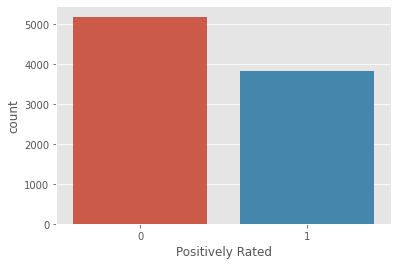

In [ ]:
sns.countplot(foodpanda_reviews["Positively Rated"])

In [ ]:
foodpanda_reviews['Positively Rated'].describe()

count    9013.000000
mean        0.424387
std         0.494277
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Positively Rated, dtype: float64

In [ ]:
foodpanda_reviews[['reviews_text_nonstop','Positively Rated']].tail(5)

,reviews_text_nonstop,Positively Rated
9995,"[apps, keep, showing, refresh, button, hard, p...",0
9996,"[im, actually, getting, bit, annoyed, app, tim...",0
9997,"[please, fix, bug, app, loads, endlessly, trie...",0
9998,"[really, good, app, sometimes, find, restauran...",1
9999,"[could, easily, order, favorite, food, app, se...",1


## Building a machine learning model

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
foodpanda_reviews['cleandata'] = [' '.join(map(str, l)) for l in foodpanda_reviews['reviews_text_nonstop']]


In [ ]:
foodpanda_reviews['cleandata'].tail(5)

9995    apps keep showing refresh button hard place or...
9996    im actually getting bit annoyed app times ok t...
9997    please fix bug app loads endlessly tried reins...
9998    really good app sometimes find restaurants sat...
9999    could easily order favorite food app secured o...
Name: cleandata, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
foodpanda_reviews['cleandata'],
foodpanda_reviews['Positively Rated'],
random_state=0)

In [ ]:
print(X_train)

8830    update 03 07 2021 1 star api issue even make p...
7357             discount ever works bugs app show errors
4807    meat section need improvement got rotten chick...
591                            love order food convenient
143     completely wrong tracking obviously fd want ta...
                              ...                        
4776                       times order arrive differently
8732    sorry foodpanda change rating 5 2 stars delive...
5348    pretty good bugs make constant updates fix bug...
3541    disappointed one time coz created another acc ...
2966    experience foodpanda quite long time order for...
Name: cleandata, Length: 6759, dtype: object


In [ ]:
X_train[0]

'pretty good live since places foodpanda discovered favorite places thru app radius shops little diaappointing jollibee within city order far sometimes issue shops become unavailable even open sure happens really frustrating'

##Unigram

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df= 5, ngram_range=(1,1)).fit(X_train)

In [ ]:
len(vect.get_feature_names())

1979

In [ ]:
X_train_vectorized = vect.transform(X_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression()

In [ ]:
# Save predictions
predictions = model.predict(vect.transform(X_test))

In [ ]:
print(predictions)

[0 1 0 ... 1 1 1]


In [ ]:
print(y_test)

8034    0
2674    1
5097    0
8817    1
3356    0
       ..
3966    0
1982    1
989     1
5091    1
2760    1
Name: Positively Rated, Length: 2254, dtype: int64


In [ ]:
# AUC
from sklearn.metrics import roc_auc_score
print("AUC score is", roc_auc_score(y_test, predictions))

AUC score is 0.8636563415739632


In [ ]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

In [ ]:
print("Negative words", feature_names[sorted_coef_index[:10]])

Negative words ['awful' 'poor' 'sucks' 'disappointing' 'expect' 'hate' 'uninstall'
 'disappointed' 'lousy' 'worse']


In [ ]:
print("Positive words", feature_names[sorted_coef_index[:-11:-1]])

Positive words ['easy' 'excellent' 'nice' 'great' 'best' 'love' 'amazing' 'fast'
 'improved' 'popping']


In [ ]:
top10 = pd.DataFrame(columns = ['id'])
top10['id']= [1,2,3,4,5,6,7,8,9,10]

In [ ]:
top10['unigram_pos']= feature_names[sorted_coef_index[:-11:-1]]
top10['unigram_neg']= feature_names[sorted_coef_index[:10]]

In [ ]:
top10

,id,unigram_pos,unigram_neg
0,1,easy,awful
1,2,excellent,poor
2,3,nice,sucks
3,4,great,disappointing
4,5,best,expect
5,6,love,hate
6,7,amazing,uninstall
7,8,fast,disappointed
8,9,improved,lousy
9,10,popping,worse


##Bigram

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df= 5, ngram_range=(2,2)).fit(X_train)

In [ ]:
len(vect.get_feature_names())

2042

In [ ]:
X_train_vectorized = vect.transform(X_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression()

In [ ]:
# Save predictions
predictions = model.predict(vect.transform(X_test))

In [ ]:
print(predictions)

[0 1 0 ... 1 0 1]


In [ ]:
print(y_test)

8034    0
2674    1
5097    0
8817    1
3356    0
       ..
3966    0
1982    1
989     1
5091    1
2760    1
Name: Positively Rated, Length: 2254, dtype: int64


In [ ]:
# AUC
from sklearn.metrics import roc_auc_score
print("AUC score is", roc_auc_score(y_test, predictions))

AUC score is 0.7708064527857067


In [ ]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

In [ ]:
print("Negative words", feature_names[sorted_coef_index[:10]])

Negative words ['waste time' 'cancelled order' 'worst app' 'poor app' 'useless app'
 'unknown error' 'bad service' 'items ordered' 'food price' 'pick order']


In [ ]:
print("Positive words", feature_names[sorted_coef_index[:-11:-1]])

Positive words ['easy use' 'fast delivery' 'easy order' 'great app' 'nice app'
 'best food' 'useful app' 'great service' 'good service'
 'great experience']


In [ ]:
top10['bigram_pos']= feature_names[sorted_coef_index[:-11:-1]]
top10['bigram_neg']= feature_names[sorted_coef_index[:10]]

##Trigram

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df= 5, ngram_range=(3,3)).fit(X_train)

In [ ]:
len(vect.get_feature_names())

218

In [ ]:
X_train_vectorized = vect.transform(X_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression()

In [ ]:
# Save predictions
predictions = model.predict(vect.transform(X_test))

In [ ]:
print(predictions)

[0 0 0 ... 0 0 0]


In [ ]:
print(y_test)

8034    0
2674    1
5097    0
8817    1
3356    0
       ..
3966    0
1982    1
989     1
5091    1
2760    1
Name: Positively Rated, Length: 2254, dtype: int64


In [ ]:
# AUC
from sklearn.metrics import roc_auc_score
print("AUC score is", roc_auc_score(y_test, predictions))

AUC score is 0.5468765779908205


In [ ]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

In [ ]:
print("Negative words", feature_names[sorted_coef_index[:10]])

Negative words ['worst app ever' 'worst food delivery' 'bad customer service'
 'poor customer service' 'worst customer service' 'get money back'
 'order got cancelled' 'better use grab' 'says unknown error'
 'estimated delivery time']


In [ ]:
print("Positive words", feature_names[sorted_coef_index[:-11:-1]])

Positive words ['easy order food' 'thank food panda' 'keep good work' 'app easy use'
 'best food delivery' 'easy use app' 'overall good experience'
 'thanks food panda' 'best food app' 'really good app']


In [ ]:
top10['trigram_pos']= feature_names[sorted_coef_index[:-11:-1]]
top10['trigram_neg']= feature_names[sorted_coef_index[:10]]

In [ ]:
top10

,id,unigram_pos,unigram_neg,bigram_pos,bigram_neg,trigram_pos,trigram_neg
0,1,easy,awful,easy use,waste time,easy order food,worst app ever
1,2,excellent,poor,fast delivery,cancelled order,thank food panda,worst food delivery
2,3,nice,sucks,easy order,worst app,keep good work,bad customer service
3,4,great,disappointing,great app,poor app,app easy use,poor customer service
4,5,best,expect,nice app,useless app,best food delivery,worst customer service
5,6,love,hate,best food,unknown error,easy use app,get money back
6,7,amazing,uninstall,useful app,bad service,overall good experience,order got cancelled
7,8,fast,disappointed,great service,items ordered,thanks food panda,better use grab
8,9,improved,lousy,good service,food price,best food app,says unknown error
9,10,popping,worse,great experience,pick order,really good app,estimated delivery time


In [ ]:
# determining the name of the file
file_name = 'top10_ngram.xlsx'
  
# saving the excel
top10.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.
